# Cell classification with SPRITE postprocessing

Classification of cells by supervised learning (predict cell type) using predicted spatial gene expression and with or without SPRITE postprocessing. Generates results associated with Figure 5 of the manuscript.

The notebook requires data files generated by the ``impute.py`` script run on all benchmark datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
import squidpy as sq
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.manifold import TSNE
import anndata as ad
import warnings
import time
import pickle
import os

from decimal import Decimal

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.stats import ttest_rel
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

In [2]:
dataset_names = ["Dataset15", "Dataset1", "Axolotl"]
metadata_labels = ["ClusterName", "celltype_mapped_refined", "Annotation"]

methods = ['knn', 'spage', 'tangram']
n_classes = 3
filter_proportion = "otsu" # 0.2, "otsu"

In [5]:

######################################


df_dict = {}
df_dict["Dataset"] = []
df_dict["Label"] = []
df_dict["Imputation Method"] = []
df_dict["Approach"] = []
df_dict["Accuracy"] = []
df_dict["F1"] = []
df_dict["ROC_AUC"] = []

for di, d in enumerate(dataset_names):

    label = metadata_labels[di]

    adata = sc.read_h5ad(f"scg_results/{d}_knn_spage_tangram.h5ad")

    # subset into observations falling into most prevalent classes (if specified)
    uniq_labels, counts = np.unique(adata.obs[label], return_counts=True)
    if len(uniq_labels) > n_classes:
        sorted_uniq_labels = uniq_labels[np.argsort(counts)][::-1][:n_classes]
        adata = adata[adata.obs[label].isin(sorted_uniq_labels)]

    for m in methods:

        predicted = f'{m}_predicted_expression_raw'

        # Imputed
        model = LogisticRegression(penalty='l1', solver='liblinear')#, tol=1e-3, max_iter=500)
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
        X = adata.obsm[predicted].values
        X = StandardScaler().fit_transform(X)
        imp_dict = cross_validate(model, X, adata.obs[label].values, cv=kf, scoring=["accuracy", "f1_macro", "roc_auc_ovr"])
        imp_acc = imp_dict['test_accuracy'].mean()
        imp_f1 = imp_dict['test_f1_macro'].mean()
        imp_roc_auc = imp_dict['test_roc_auc_ovr'].mean()
        
        # SPRITE
        model = LogisticRegression(penalty='l1', solver='liblinear')#, tol=1e-3, max_iter=500)
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
        X = adata.obsm['smoothed_reinforced_gene_joint_'+predicted].values
        X = StandardScaler().fit_transform(X)
        unc_dict = cross_validate(model, X, adata.obs[label].values, cv=kf, scoring=["accuracy", "f1_macro", "roc_auc_ovr"])
        unc_acc = unc_dict['test_accuracy'].mean()
        unc_f1 = unc_dict['test_f1_macro'].mean()
        unc_roc_auc = unc_dict['test_roc_auc_ovr'].mean()

        # Measured
        model = LogisticRegression(penalty='l1', solver='liblinear')#, tol=1e-3, max_iter=500)
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
        X = adata.X
        X = StandardScaler().fit_transform(X)
        measured_dict = cross_validate(model, X, adata.obs[label].values, cv=kf, scoring=["accuracy", "f1_macro", "roc_auc_ovr"])
        measured_acc = measured_dict['test_accuracy'].mean()
        measured_f1 = measured_dict['test_f1_macro'].mean()
        measured_roc_auc = measured_dict['test_roc_auc_ovr'].mean()

        # Append results to dictionary
        df_dict["Dataset"] += [d,d,d]
        df_dict["Label"] += [label, label, label]
        df_dict["Imputation Method"] += [m,m,m]
        df_dict["Approach"] += ["Baseline", "SPRITE", "Measured"]
        df_dict["Accuracy"] += [imp_acc, unc_acc, measured_acc]
        df_dict["F1"] += [imp_f1, unc_f1, measured_f1]
        df_dict["ROC_AUC"] += [imp_roc_auc, unc_roc_auc, measured_roc_auc]

In [6]:
# with open(f"results/prediction/CellsClassAccuracy_LogReg_K{n_classes}_OtsuFilterInCV.pkl", "wb") as f:
#     pickle.dump(df_dict, f)

## Figure 5 BCD: Classification performance with SPRITE

In [4]:
with open(f"results/prediction/CellsClassAccuracy_LogReg_K{n_classes}_OtsuFilterInCV.pkl", "rb") as f:
    df_dict = pickle.load(f)

In [5]:
df = pd.DataFrame(df_dict)
df["Dataset"] = [x.split("Dataset")[1] if len(x.split("Dataset"))>1 else x for x in df["Dataset"].values]
df["Dataset_Label"] = df["Dataset"] + df["Label"]

/tmp/ipykernel_3905/235805454.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x="Approach", y="Accuracy", c='k', order=["Measured", "Baseline", "SPRITE"], palette=plot_palette2)


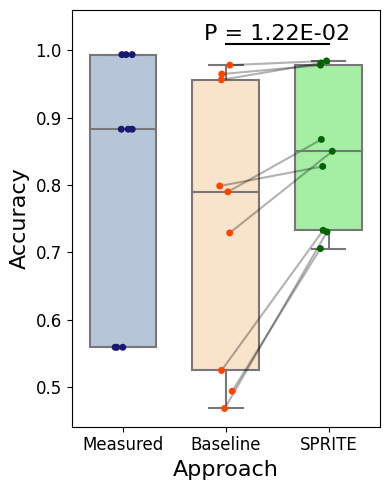

In [6]:
fig, ax = plt.subplots(figsize=(4,5))


plot_palette = {"Baseline": "bisque", "SPRITE": "palegreen", "Measured":'lightsteelblue'}
plot_palette2 = {"Baseline": "orangered", "SPRITE": "darkgreen", "Measured":'midnightblue'}

sns.stripplot(data=df, x="Approach", y="Accuracy", c='k', order=["Measured", "Baseline", "SPRITE"], palette=plot_palette2)
sns.boxplot(data=df, x="Approach", y="Accuracy", width=0.65, order=["Measured", "Baseline", "SPRITE"], palette=plot_palette)

# Draw connecting lines
locs1 = ax.get_children()[1].get_offsets()
locs2 = ax.get_children()[2].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.3)
    
# statistical annotation
x_coords = [1.5]
y_coords = [1.01]
cols = ['k']
h = 0
w = 0.5
t,p = ttest_rel(df[df["Approach"]=="Baseline"]["Accuracy"], df[df["Approach"]=="SPRITE"]["Accuracy"])
pval_labels = [p]
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
    
plt.ylim(None, y+0.05)
    
plt.xlabel("Approach", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/sprite_prediction/predictionMetadata_LogReg_ACC.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_3905/3253725637.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x="Approach", y="F1", c='k', order=["Measured", "Baseline", "SPRITE"], palette=plot_palette2)


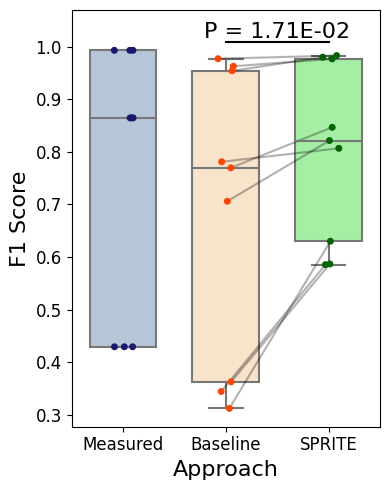

In [7]:
fig, ax = plt.subplots(figsize=(4,5))

plot_palette = {"Baseline": "bisque", "SPRITE": "palegreen", "Measured":'lightsteelblue'}
plot_palette2 = {"Baseline": "orangered", "SPRITE": "darkgreen", "Measured":'midnightblue'}

sns.stripplot(data=df, x="Approach", y="F1", c='k', order=["Measured", "Baseline", "SPRITE"], palette=plot_palette2)
sns.boxplot(data=df, x="Approach", y="F1", width=0.65, order=["Measured", "Baseline", "SPRITE"], palette=plot_palette)

# Draw connecting lines
locs1 = ax.get_children()[1].get_offsets()
locs2 = ax.get_children()[2].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.3)
    
# statistical annotation
x_coords = [1.5]
y_coords = [1.01]
cols = ['k']
h = 0
w = 0.5
t,p = ttest_rel(df[df["Approach"]=="Baseline"]["F1"], df[df["Approach"]=="SPRITE"]["F1"])
pval_labels = [p]
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
    
plt.ylim(None, y+0.06)
    
plt.xlabel("Approach", fontsize=16)
plt.ylabel("F1 Score", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/sprite_prediction/predictionMetadata_LogReg_F1.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_3905/2325717635.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x="Approach", y="ROC_AUC", c='k', order=["Measured", "Baseline", "SPRITE"], palette=plot_palette2)


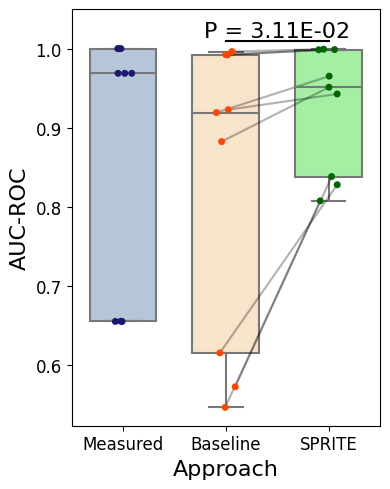

In [8]:
fig, ax = plt.subplots(figsize=(4,5))

plot_palette = {"Baseline": "bisque", "SPRITE": "palegreen", "Measured":'lightsteelblue'}
plot_palette2 = {"Baseline": "orangered", "SPRITE": "darkgreen", "Measured":'midnightblue'}

sns.stripplot(data=df, x="Approach", y="ROC_AUC", c='k', order=["Measured", "Baseline", "SPRITE"], palette=plot_palette2)
sns.boxplot(data=df, x="Approach", y="ROC_AUC", width=0.65, order=["Measured", "Baseline", "SPRITE"], palette=plot_palette)

# Draw connecting lines
locs1 = ax.get_children()[1].get_offsets()
locs2 = ax.get_children()[2].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.3)
    
# statistical annotation
x_coords = [1.5]
y_coords = [1.01]
cols = ['k']
h = 0
w = 0.5
t,p = ttest_rel(df[df["Approach"]=="Baseline"]["ROC_AUC"], df[df["Approach"]=="SPRITE"]["ROC_AUC"])
pval_labels = [p]
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
    
plt.ylim(None, y+0.04)
    
plt.xlabel("Approach", fontsize=16)
plt.ylabel("AUC-ROC", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/sprite_prediction/predictionMetadata_LogReg_ROCAUC.pdf", bbox_inches="tight")
plt.show()